In [2]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)

import matplotlib.pyplot as plt
#% matplotlib inline
#%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import imgaug.augmenters as iaa

from PIL import Image
import random

1.17.0
0.15.0
1.14.0


In [3]:
import tensorflow as tf

In [14]:
from albumentations import (
    Compose, HorizontalFlip, Rotate,GaussNoise ,RandomCrop,
    RandomBrightness, RandomContrast,OneOf,
    ToFloat, ShiftScaleRotate,PadIfNeeded
)
import cv2

In [0]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
                            Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
                            IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
                            IAASharpen, IAAEmboss, Flip, OneOf, Compose, ChannelShuffle,RandomContrast, RandomCrop)

In [4]:
tf.enable_eager_execution()

In [8]:
BATCH_SIZE = 512 
MOMENTUM = 0.9
LEARNING_RATE = 0.6
WEIGHT_DECAY = 0.125
EPOCHS = 24
cutout_proba = 0.2
ssr_proba = 0.15
strong_aug_proba = 0.05

start_reg_ssr = 5
end_reg_ssr = 24

start_strong_aug = 3
end_strong_aug = 12

mixed_precision = False
xla_enabled = False

In [9]:
if xla_enabled:
    config = tf.ConfigProto()
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level

    sess = tf.Session(config=config)
    tf.keras.backend.set_session(sess)


In [10]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / (math.sqrt(fan))
    return tf.random_uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

class ConvBN(tf.keras.Model):
    def __init__(self, c_out, BN=True, kernel_size=3, strides=1):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=kernel_size, strides=strides, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.BN = BN
    def call(self, inputs):
        if self.BN:
            return tf.nn.relu(self.bn(self.conv(inputs)))
        else:
            return tf.nn.relu(self.conv(inputs))
    
    
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False, pooling=False, BN=True):
        super().__init__()
        self.pool = pool
        self.res = res
        self.pooling = pooling
        self.BN = BN
        self.conv_bn = ConvBN(c_out, BN=True)
        if self.res:
            self.res1 = ConvBN(c_out, BN=True)
            self.res2 = ConvBN(c_out, BN=True)

    def call(self, inputs):
        if self.pooling:
            h = self.pool(self.conv_bn(inputs))
        else:
            h = self.conv_bn(inputs)
        
        if self.res:
            residual = self.res2(self.res1(h))
            h = h + residual
        return h
    
class ResBlk_3(tf.keras.Model):
    def __init__(self, c_out, pool, res = False, pooling=False, BN=True):
        super().__init__()
        self.pool = pool
        self.res = res
        self.pooling = pooling
        self.BN = BN
        self.conv_bn = ConvBN(c_out, BN=True)
        if self.res:
            self.res1 = ConvBN(c_out, BN=True)
            self.res2 = ConvBN(c_out, BN=True)

    def call(self, inputs):
        if self.pooling:
            h = self.pool(self.conv_bn(inputs))
        else:
            h = self.conv_bn(inputs)
        
        if self.res:
            residual = self.res2(self.res1(h))
            h = h + residual
        return h
    
    
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c,  BN = False)
        self.skip = ConvBN(c, kernel_size=1, strides=2, BN = False)
        self.blk1 = ResBlk(c*2, pool, res = True, pooling = True, BN = False)
        self.blk2 = ResBlk(c*4, pool, pooling = True, BN = False)
        self.blk3 = ResBlk(c*8, pool, res = True, pooling = True,  BN = False)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-4)
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-4)
        self.bn3 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-4)
        self.bn4 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-4)

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct


In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [15]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)


# Cutout implimentation it's return eraser crop images With thir mean values
def get_cutout_eraser(p=0.4, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1/0.3, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=False):
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.mean(input_img, axis=(0,1))

            input_img[top:top + h, left:left + w, :] = c
        return input_img

    return eraser


def multiple_aug(x, y):
    x = tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))
    return (x, y)

data_aug = lambda x, y: multiple_aug(x, y)


cutout_fn = get_cutout_eraser(p=0.5, pixel_level=False)

def batch_cut(imgs, epoch):
    if epoch>=24 or epoch<=1:
        return imgs
    for i,im in enumerate(imgs):
        p_1 = np.random.rand()
        if p_1 > cutout_proba:
            continue
        else:
            imgs[i] = cutout_fn(im)
    return imgs


ssr = ShiftScaleRotate(p=ssr_proba)
rotate_one = lambda x: ssr(image=x)['image']

def rotate(imgs,epoch):
    if epoch>=end_reg_ssr or epoch<=start_reg_ssr:
        return imgs
    for i,im in enumerate(imgs):
        imgs[i] = rotate_one(im)
    return imgs


AUGMENTATIONS_FOR_TRAIN = Compose([GaussNoise(p=0.25),
                      RandomContrast(limit=0.2, p=0.5),
                      HorizontalFlip(p=0.5),
                      RandomCrop(40,40,p=1.0),
                      PadIfNeeded(40,40),
                      RandomBrightness(limit=0.2, p=0.5),
                      ShiftScaleRotate(shift_limit=0.052, scale_limit=0.1, 
                                       rotate_limit=0, border_mode=cv2.BORDER_REFLECT_101, p=0.8)],
                     p=strong_aug_proba)


mix_aug = lambda x: AUGMENTATIONS_FOR_TRAIN(image=x)['image']
def other_augs(imgs,epoch):
    if epoch>=24 or epoch<=15:
        return imgs
    for i,im in enumerate(imgs):
        imgs[i] = mix_aug(im)
    return imgs

#Apply AUG epoch wise
def combined_aug(imgs,epoch):
    imgs = np.copy(imgs)
    imgs = rotate(imgs,epoch)
    imgs = batch_cut(imgs,epoch)
    imgs = other_augs(imgs,epoch)
    return imgs



13


In [10]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)


28


In [14]:
import dill as pickle
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    xt = combined_aug(x_train, epoch)
#     print(type(xt))
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
#     train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(BATCH_SIZE).prefetch(len_train)
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
    with open('train_data_'+str(epoch)+'.pkl', 'wb') as file:
        pickle.dump(train_set, file)
t2 = time.time()
"%.1f" %(t2-t1)

NameError: ignored

In [0]:
import dill as pickle



In [16]:

t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    xt = combined_aug(x_train, epoch)
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
    train_data[epoch] = train_set
t2 = time.time()
"%.1f" %(t2-t1)

'238.6'

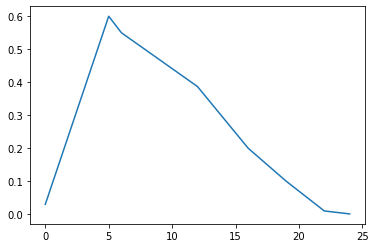

In [17]:

lr_schedule = lambda t: np.interp([t], [0,     5,    6,     12,     16,  19, 22, 24], 
                                      [0.03,  0.6, 0.55,  0.387,  0.2,  0.1,0.01,0.001])[0] ### ran with weight decay 0.125 93.25 in 23, 93.19 in 24

#lr_schedule = lambda t: np.interp([t], [0,     5,    6,     12,     16,  19, 22, 24], 
#                                         [0.03,  0.6, 0.58,  0.387,  0.2,  0.1,0.01,0.001])[0] ### ran with weight decay 0.125 93.4 
lr=[]
ep=[]
for i in range(25):
    lr.append(lr_schedule(i))
    ep.append(i)

import matplotlib.pyplot as plt 
plt.plot(ep, lr)

0
time for test 0.9994926452636719
epoch: 1 lr: 0.1440 | train loss: 1.3743 train acc: 0.5027 val loss: 1.0482 | val acc: 0.6385 epoch time: 18.70 time: 18.70
19.367353677749634
time for test 0.782437801361084
epoch: 2 lr: 0.2580 | train loss: 0.7960 train acc: 0.7211 val loss: 1.0994 | val acc: 0.6601 epoch time: 13.32 time: 13.32
33.19805884361267
time for test 0.7424001693725586
epoch: 3 lr: 0.3720 | train loss: 0.6762 train acc: 0.7653 val loss: 0.9584 | val acc: 0.7227 epoch time: 13.13 time: 13.13
46.81713604927063
time for test 0.7834203243255615
epoch: 4 lr: 0.4860 | train loss: 0.5902 train acc: 0.7983 val loss: 0.5442 | val acc: 0.8162 epoch time: 13.08 time: 13.08
60.403240442276
time for test 0.7371304035186768
epoch: 5 lr: 0.6000 | train loss: 0.5144 train acc: 0.8239 val loss: 0.7494 | val acc: 0.7581 epoch time: 13.07 time: 13.07
74.17261672019958
time for test 0.7429518699645996
epoch: 6 lr: 0.5500 | train loss: 0.4285 train acc: 0.8516 val loss: 0.6470 | val acc: 0.791

<Figure size 432x288 with 0 Axes>

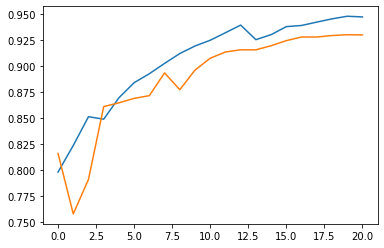

In [18]:
print(gc.collect())
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

t_start = time.time()
# t_last = time.time()
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    # train_set = dataset.batch(512)
    tf.keras.backend.set_learning_phase(1)

    t = time.time()
    t_last = time.time()
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    kk = time.time()
    
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()
    mm = time.time()
    print("time for test",mm-kk)
    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)

    
    print("epoch: %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.4f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), '| val acc: %.4f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
    print(time.time()-t_start)
    
plt.figure()
plt.plot(train_accs[3:])
plt.plot(test_accs[3:])
plt.show()